In [ ]:
## Triplet's rate equation solving

[0.] [-1.21652087e+13  0.00000000e+00]
[0.82081607] [-1.21652087e+13  8.20816065e-01]
[1.64163213] [-1.21652087e+13  1.64163213e+00]
[2.4624482] [-1.21652087e+13  2.46244820e+00]
[3.28326426] [-1.21652087e+13  3.28326426e+00]
[4.10408033] [-1.21652087e+13  4.10408033e+00]
[4.92489639] [-1.21652087e+13  4.92489639e+00]
[5.74571246] [-1.21652087e+13  5.74571246e+00]
[6.56652852] [-1.21652087e+13  6.56652852e+00]
[7.38734459] [-1.21652087e+13  7.38734459e+00]
[0.+10.66034708j 0.-10.66034708j 0. +0.j        ] [-1.21652087e+13  0.00000000e+00]
[-0.40801718+10.68374625j -0.40801718-10.68374625j
  0.81603436 +0.j        ] [-1.21652087e+13  8.20816065e-01]
[-0.80261726+10.75060851j -0.80261726-10.75060851j
  1.60523453 +0.j        ] [-1.21652087e+13  1.64163213e+00]
[-1.17423608+10.852626j -1.17423608-10.852626j  2.34847216 +0.j      ] [-1.21652087e+13  2.46244820e+00]
[-1.51841097+10.97996883j -1.51841097-10.97996883j
  3.03682194 +0.j        ] [-1.21652087e+13  3.28326426e+00]
[-1.83467323+1

[-0.74211345+2.23486874j -0.74211345-2.23486874j  1.48422689+0.j        ] [-1.21652087e+13  2.46244820e+00]
[-0.86556694+2.36433068j -0.86556694-2.36433068j  1.73113388+0.j        ] [-1.21652087e+13  3.28326426e+00]
[-0.96766972+2.48024096j -0.96766972-2.48024096j  1.93533944+0.j        ] [-1.21652087e+13  4.10408033e+00]
[-1.05543984+2.58540151j -1.05543984-2.58540151j  2.11087969+0.j        ] [-1.21652087e+13  4.92489639e+00]
[-1.13287669+2.68191535j -1.13287669-2.68191535j  2.26575338+0.j        ] [-1.21652087e+13  5.74571246e+00]
[-1.20247787+2.77133547j -1.20247787-2.77133547j  2.40495574+0.j        ] [-1.21652087e+13  6.56652852e+00]
[-1.2659112+2.85482656j -1.2659112-2.85482656j  2.5318224+0.j        ] [-1.21652087e+13  7.38734459e+00]
[0.+1.80192754j 0.-1.80192754j 0.+0.j        ] [-1.21652087e+13  0.00000000e+00]
[-0.35519983+1.90405977j -0.35519983-1.90405977j  0.71039966+0.j        ] [-1.21652087e+13  8.20816065e-01]
[-0.58020151+2.06321211j -0.58020151-2.06321211j  1.160403

[-0.62844141+1.68279999j -0.62844141-1.68279999j  1.25688282+0.j        ] [-1.21652087e+13  2.46244820e+00]
[-0.72315842+1.79328589j -0.72315842-1.79328589j  1.44631684+0.j        ] [-1.21652087e+13  3.28326426e+00]
[-0.80151048+1.89057059j -0.80151048-1.89057059j  1.60302096+0.j        ] [-1.21652087e+13  4.10408033e+00]
[-0.86895046+1.97793446j -0.86895046-1.97793446j  1.73790093+0.j        ] [-1.21652087e+13  4.92489639e+00]
[-0.92853917+2.05756045j -0.92853917-2.05756045j  1.85707835+0.j        ] [-1.21652087e+13  5.74571246e+00]
[-0.98217529+2.13096338j -0.98217529-2.13096338j  1.96435059+0.j        ] [-1.21652087e+13  6.56652852e+00]
[-1.03112289+2.19923697j -1.03112289-2.19923697j  2.06224578+0.j        ] [-1.21652087e+13  7.38734459e+00]
[0.+1.27415518j 0.-1.27415518j 0.+0.j        ] [-1.21652087e+13  0.00000000e+00]
[-0.32546495+1.39328882j -0.32546495-1.39328882j  0.6509299 +0.j        ] [-1.21652087e+13  8.20816065e-01]
[-0.50448038+1.5449831j -0.50448038-1.5449831j  1.00896

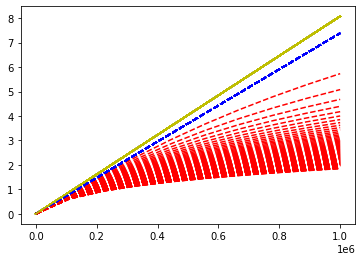

In [67]:
import numpy as np
import matplotlib.pyplot as plt

k_isc = 1E-3    # 1/ns
tau_s = 98       # 1/ns
k_risc = 100*1E+3 # 1/ns
tau_t = 2.2E-4   # 1/ns
G = np.linspace(0,1E+6,10)
k_tta = 7*1E-9 # From literature (m^3/ns)
param_corr_arr = np.linspace(0,1E+5,100) # Our parameter m^6/ns
lambda_coef = (1+k_isc*tau_s)/k_isc

def calculate_coefs(k_isc,tau_s,k_risc,tau_t,k_tta,param_corr):
    lambda_coef = (1+k_isc*tau_s)/k_isc
    
    a_corr = tau_s*param_corr - lambda_coef*param_corr
    b_corr = k_isc*tau_s -lambda_coef/tau_t - k_risc*lambda_coef
    c_corr = 0.25*tau_s+lambda_coef*0.75

    a_conv = 0.25*tau_s*k_tta - lambda_coef*1.25*k_tta
    b_conv = b_corr
    c_conv = c_corr
    #p = (5*k_tta+4*k_tta*k_isc*tau_s)
    #a_conv = 1
    #b_conv = (4*(1/tau_t)+4*k_isc*tau_s*(1/tau_t)+4*k_risc)/p
    #c_conv = (4*0.75+4*k_isc*tau_s)/p
    
    return a_corr,b_corr,c_corr,a_conv,b_conv,c_conv
    
def triplet_correction(G,a_corr,b_corr,c_corr): # root of a_corrT^3 + 0*T^2 + b_corr*T + G*c_corr = 0
    return np.roots([a_corr,0,b_corr,G*c_corr])

def triplet_convetional(G,a_conv,b_conv,c_conv): # root of a_corrT^2 b_corr*T + G*c_corr = 0
    return np.roots([a_conv,b_conv,G*c_conv])

def article_expression(g): # the exact expression from the article (debug purposes)
    c1  = (5*k_tta + 4*k_tta*k_isc*tau_s)
    c2  = (1/tau_t + k_isc*tau_s/tau_t +k_risc)
    c3  = c2/c1
    c4  = (0.75*g + k_isc*tau_s*g)/c1
    #print(c1,c2,c3,c4)
    return -2*c3 + np.sqrt(4*c3*c3 + 4*c4)

tcorr      = [] # Triplet density for a given G
tconv      = [] # Triplet density for a given G
tarticle   = [] # Triplet density for a given G
g_allowed  = [] # G values in which the polynomials' roots are real

for param_corr in param_corr_arr:
    tcorr      = [] # Triplet density for a given G
    tconv      = [] # Triplet density for a given G
    tarticle   = [] # Triplet density for a given G
    g_allowed  = [] # G values in which the polynomials' roots are real
    for g in G:

        a_corr,b_corr,c_corr,a_conv,b_conv,c_conv = calculate_coefs(k_isc,tau_s,k_risc,tau_t,k_tta,param_corr)

        sols_corr = triplet_correction(g,a_corr,b_corr,c_corr)
        real_sols_corr = [x.real for x in sols_corr if x.imag == 0 and x.real >=0]

        sols_conv = triplet_convetional(g,a_conv,b_conv,c_conv)
        real_sols_conv = [x.real for x in sols_conv if x.imag == 0 and x.real >=0]
        
        if real_sols_corr and real_sols_conv:
            
            if len(real_sols_corr) > 1 or len(real_sols_conv) > 1:
                print('duplicated sols')
                
            print(sols_corr,sols_conv)
            tcorr.append(real_sols_corr[0])
            tconv.append(real_sols_conv[-1])
            tarticle.append(article_expression(g))
            g_allowed.append(g)
        
    plt.plot(g_allowed,tconv,'--b',label='conventional')
    plt.plot(g_allowed,tcorr,'--r',label='corrected(%s)'%(param_corr))
    plt.plot(g_allowed,tarticle,'-y',label='article')
    #plt.legend()
    #plt.show()
    
#plt.legend()
plt.show()


In [44]:
b = k_isc*tau_s -lambda_coef/tau_t - k_risc*lambda_coef
a = 0.25*tau_s*k_tta - lambda_coef*1.25*k_tta
c = 0.25*tau_s+lambda_coef*0.75

ba_gabarito = (4*(1/tau_t)+4*k_isc*tau_s*(1/tau_t)+4*k_risc)/(5*k_tta+4*k_tta*k_isc*tau_s)
ca_cabarito = (4*0.75+4*k_isc*tau_s)/(5*k_tta+4*k_tta*k_isc*tau_s)
print(b/a,c/a)
print(ba_gabarito,ca_cabarito)

12165208668176.037 -89868588.38490885
11126633010906.006 89868588.38490885
